In [11]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import math

In [12]:
# x and y grid limits
grid_x = np.array([6,15])
grid_y = np.array([-4.5,4.5])

# z for travel and write
z_travel = 4
z_write = 0

# robot rest position
rest_pos = np.array([(grid_x[0]+grid_x[1])/2,(grid_y[0]+grid_y[1])/2])

# travel and write velocity (translates to sampling rate)
travel_v = 0.1
write_v = 0.05

# drawing radius
radius = 0.75 * (grid_x[1]-grid_x[0])/6

In [13]:
# center coordinates of each grid square
row1 = grid_x[0] + (grid_x[1] - grid_x[0])*1/6
row2 = grid_x[0] + (grid_x[1] - grid_x[0])*3/6
row3 = grid_x[0] + (grid_x[1] - grid_x[0])*5/6

col1 = grid_y[0] + (grid_y[1] - grid_y[0])*1/6
col2 = grid_y[0] + (grid_y[1] - grid_y[0])*3/6
col3 = grid_y[0] + (grid_y[1] - grid_y[0])*5/6

c1 = np.array([row1,col1])
c2 = np.array([row1,col2])
c3 = np.array([row1,col3])
c4 = np.array([row2,col1])
c5 = np.array([row2,col2])
c6 = np.array([row2,col3])
c7 = np.array([row3,col1])
c8 = np.array([row3,col2])
c9 = np.array([row3,col3])

In [14]:
# path-creator functions

# straight line
def move_to(x1,y1,z1,x2,y2,z2,velocity):
    dist = np.sqrt((x2-x1)**2+(y2-y1)**2+(z2-z1)**2)
    
    num_samples = int(np.ceil(dist/velocity))
    
    waypoint_x = np.linspace(x1,x2,num_samples,endpoint=True)
    waypoint_y = np.linspace(y1,y2,num_samples,endpoint=True)
    waypoint_z = np.linspace(z1,z2,num_samples,endpoint=True)

    return waypoint_x, waypoint_y, waypoint_z

# O
def draw_circle(x0,y0,radius,velocity):
    global z_travel
    global z_write

    path_x1, path_y1, path_z1 = move_to(x0,y0,z_travel,x0+radius,y0,z_write,velocity)
    
    dist = 2*np.pi*radius
    num_samples = int(np.ceil(dist/velocity))
    
    si = np.linspace(0,2*np.pi,num_samples,endpoint=True)

    path_x2 = x0 + radius*np.cos(si)
    path_y2 = y0 + radius*np.sin(si)
    path_z2 = np.ones_like(path_x2) * z_write

    path_x3, path_y3, path_z3 = move_to(x0+radius,y0,z_write,x0,y0,z_travel,velocity)

    waypoint_x = np.concatenate((path_x1, path_x2, path_x3))
    waypoint_y = np.concatenate((path_y1, path_y2, path_y3))
    waypoint_z = np.concatenate((path_z1, path_z2, path_z3))

    return waypoint_x, waypoint_y, waypoint_z

# X
def draw_cross(x0,y0,radius,velocity):
    global z_travel
    global z_write

    path_x1, path_y1, path_z1 = move_to(x0,y0,z_travel,x0-radius,y0+radius,z_write,velocity)
    path_x2, path_y2, path_z2 = move_to(x0-radius,y0+radius,z_write,x0+radius,y0-radius,z_write,velocity)
    path_x3, path_y3, path_z3 = move_to(x0+radius,y0-radius,z_write,x0+radius,y0-radius,z_travel,velocity)
    path_x4, path_y4, path_z4 = move_to(x0+radius,y0-radius,z_travel,x0-radius,y0-radius,z_travel,velocity)
    path_x5, path_y5, path_z5 = move_to(x0-radius,y0-radius,z_travel,x0-radius,y0-radius,z_write,velocity)
    path_x6, path_y6, path_z6 = move_to(x0-radius,y0-radius,z_write,x0+radius,y0+radius,z_write,velocity)
    path_x7, path_y7, path_z7 = move_to(x0+radius,y0+radius,z_write,x0,y0,z_travel,velocity)


    waypoint_x = np.concatenate((path_x1, path_x2, path_x3, path_x4, path_x5, path_x6, path_x7))
    waypoint_y = np.concatenate((path_y1, path_y2, path_y3, path_y4, path_y5, path_y6, path_y7))
    waypoint_z = np.concatenate((path_z1, path_z2, path_z3, path_z4, path_z5, path_z6, path_z7))

    return waypoint_x, waypoint_y, waypoint_z

In [15]:
# get the whole path, including travel, drawing and going back to rest position
def get_path(square,symbol): #square contains the coordinates, symbol is -1 or 1 (for O or X)
    global rest_pos
    global radius
    global travel_v
    global write_v
    
    px_1, py_1, pz_1 = move_to(rest_pos[0],rest_pos[1],z_travel,square[0],square[1],z_travel,travel_v)
    if (symbol == 1):
        px_2, py_2, pz_2 = draw_cross(square[0],square[1],radius,write_v)
    elif (symbol == -1):
        px_2, py_2, pz_2 = draw_circle(square[0],square[1],radius,write_v)

    px_3 = px_1[::-1].copy()
    py_3 = py_1[::-1].copy()
    pz_3 = pz_1[::-1].copy()

    waypoint_x = np.concatenate((px_1, px_2, px_3))
    waypoint_y = np.concatenate((py_1, py_2, py_3))
    waypoint_z = np.concatenate((pz_1, pz_2, pz_3))

    return waypoint_x, waypoint_y, waypoint_z

In [16]:
# Link lengths and shoulder height (same as in forward_kinematics_points)
L1 = 6.1   # Shoulder → elbow
L2 = 11.5   # Elbow → end effector
H  = 6.8   # Shoulder height above ground

def inverse_kinematics_point(x, y, z, elbow_up=False): # ta ao contrario o booleano
    """
    Compute inverse kinematics for the 3-DOF arm.

    Args:
        x, y, z: Desired end-effector coordinates.
        elbow_up: If True, returns the "elbow-up" solution; otherwise "elbow-down".

    Returns:
        (theta1_deg, theta2_deg, theta3_deg): Joint angles in degrees.
    
    Raises:
        ValueError: If the point is out of reach.
    """
    # 1) XY-plane yaw:
    #    φ = θ1_rad
    phi = math.atan2(y, x)
    #    Map back to user angle:
    theta1_deg = math.degrees(phi + math.pi/2)

    # 2) Project into the shoulder's pitch plane:
    #    Horizontal distance from shoulder:
    r = math.hypot(x, y)
    #    Vertical offset from shoulder:
    dz = z - H

    # 3) Two‑link planar IK:
    D = (r*r + dz*dz - L1*L1 - L2*L2) / (2 * L1 * L2)
    if abs(D) > 1.0:
        raise ValueError(f"Point ({x}, {y}, {z}) is out of reach (|D|={D:.3f}>1).")

    # elbow angle:
    if elbow_up:
        theta3_rad = math.atan2(+math.sqrt(1 - D*D), D)
    else:
        theta3_rad = math.atan2(-math.sqrt(1 - D*D), D)

    # shoulder pitch:
    #    α = atan2(dz, r)
    #    β = atan2(L2*sinθ3, L1 + L2*cosθ3)
    alpha = math.atan2(dz, r)
    beta  = math.atan2(L2 * math.sin(theta3_rad), L1 + L2 * math.cos(theta3_rad))
    theta2_rad = alpha - beta

    # 4) Map back to your original angle conventions:
    #    forward did: θ2_rad = π - rad(theta2_deg)  →  theta2_deg = degrees(π - θ2_rad)
    theta2_deg = math.degrees(math.pi - theta2_rad)

    #    forward did: θ3_rad = rad(theta3_deg) - π  →  rad(theta3_deg) = θ3_rad + π
    theta3_deg = math.degrees(theta3_rad + math.pi)

    return theta1_deg, theta2_deg, theta3_deg

In [17]:
for_robot = True # False for the robot simulation
closed_grip = 1 # 1 for yes, 2 for open grip, and 0 for robot simulation (no grip relevance)
funcs = [
    lambda x: 180/145 * x - 180*15/145,     # for column 0
    lambda x: 90/85 * x - 90*15/85,      # for column 1
    lambda x: 4/3 * x - 200/3     # for column 2
]

folder = 'paths'
os.makedirs(folder, exist_ok=True)

waypoint_x = np.empty
waypoint_y = np.empty
waypoint_z = np.empty

for i in range(1, 10):
    for j in [-1,1]:
        joints = np.array([90,90,90])
        code = f"waypoint_x, waypoint_y, waypoint_z = get_path(c{i},{j})"
        exec(code)

        a = waypoint_x.reshape(-1, 1)
        b = waypoint_y.reshape(-1, 1)
        c = waypoint_z.reshape(-1, 1)
        coord = np.hstack((a,b,c))

        for row in coord:
            angles = np.array(inverse_kinematics_point(row[0], row[1], row[2], elbow_up=False)).reshape(1,-1)
            joints = np.vstack((joints,angles))

        if (for_robot):
            corrected_angs = np.array([
                [funcs[i](line[i]) for i in range(len(line))]
                for line in joints
            ])

        if (closed_grip == 1): # means yes
            new_col = np.full((corrected_angs.shape[0], 1), 170)
            corrected_angs = np.hstack((corrected_angs, new_col))

        elif (closed_grip == 2): # means no
            new_col = np.full((corrected_angs.shape[0], 1), 90)
            corrected_angs = np.hstack((corrected_angs, new_col))
            
        filename = f"c{i}symbol{j}.npy"
        filepath = os.path.join(folder, filename)
        np.save(filepath, corrected_angs)

**To visualize the paths created in (x,y,z):**

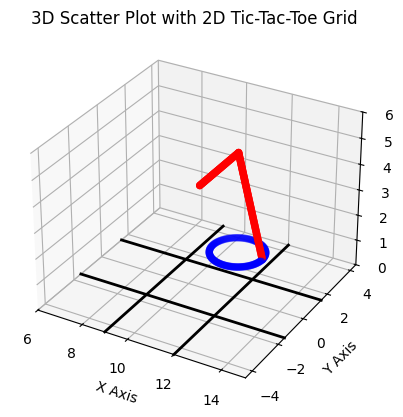

In [18]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

# Testar um determinado movimento:
waypoint_x, waypoint_y, waypoint_z = get_path(c6,-1)

colors = ['b' if zi == 0 else 'r' for zi in waypoint_z]
ax.scatter(waypoint_x, waypoint_y, waypoint_z, color=colors, marker='o')

grid_x = [9,12]  # X grid lines
grid_y = [-1.5,1.5]  # Y grid lines

for gx in grid_x:
    ax.plot([gx, gx], [-4.5,4.5], [0, 0], color='black', linewidth=2)  # Vertical lines

for gy in grid_y:
    ax.plot([6,15], [gy, gy], [0, 0], color='black', linewidth=2)  # Horizontal lines

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('3D Scatter Plot with 2D Tic-Tac-Toe Grid')

ax.set_xlim(6, 15)
ax.set_ylim(-4.5, 4.5)
ax.set_zlim(0, 6)

plt.show()